Run the cell below to import the required packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

### Recommendation systems

Recommendation systems can be thought of as applying SVD to a User/Item matrix.

In this case our decomposition has a new interpretation:
- $\Sigma$ are the importances of each of our latent features
- $U$ is a transformation from a person's buying habits/reviews to the latent features that represent their preferences
- $V$ is a transformation from the list of people who like this item, to the latent features of the item

Note that **latent features** are features that we don't directly observe but can be extracted typically by some algorithm.

By setting a large number of our singular values (eigenvalues) to 0, and reconstructing the original matrix, we will gain an estimate of how much each user will like each item.

### Simplified example

First, let's generate a really simple data set. Each row is a user, and each column is an item. If the value for a user:item location is 1; that user has "liked" that item. If it is a 0, then they do not like that item.

In [2]:
num_users = 10
num_items = 5

In [3]:
df = pd.DataFrame(np.array([[0,1,0,1,0],[1,0,0,0,1],[1,1,1,0,1],[0,0,1,1,0],[0,0,1,0,0],[1,1,1,0,1],[0,0,1,0,0],
                [1,0,0,0,1],[1,0,0,1,0],[0,0,1,0,0]]))
df

,0,1,2,3,4
0,0,1,0,1,0
1,1,0,0,0,1
2,1,1,1,0,1
3,0,0,1,1,0
4,0,0,1,0,0
5,1,1,1,0,1
6,0,0,1,0,0
7,1,0,0,0,1
8,1,0,0,1,0
9,0,0,1,0,0


Notice in the above matrix that items 0 and 4 have a lot of overlapping users. Users that like Item 0 tend to also like Item 4.

So if we take the dot products of items, we expect that items 0 & 4 are the most similar:

In [4]:
compare_item = 0
for item in range(num_items):
    if item != compare_item:
        print(f"Item {compare_item} & {item}: Dot Product = {np.dot(df[compare_item],df[item])}")

Item 0 & 1: Dot Product = 2
Item 0 & 2: Dot Product = 2
Item 0 & 3: Dot Product = 1
Item 0 & 4: Dot Product = 4


We can generalize the above calculations in order to make a function that returns recommendations for a given item input (this user likes item 0... so she'll probably also like items X, Y, Z).

In [5]:
def get_item_recommendations(compare_item, df, num_recom):
    recs = []
    for item in range(num_items):
        if item != compare_item:
            recs.append((np.dot(df[compare_item],df[item]), item))
    recs.sort(reverse = True)
    final_rec = [recs[i][1] for i in range(num_recom)]
    return final_rec

item = 0
print(f"Items similar to item {item}: {get_item_recommendations(item,df,3)}")

Items similar to item 0: [4, 2, 1]


Now notice in the original matrix that users 2 and 5 like exactly the same items.

If we compare users, we expect that users 2 & 5 should be the most similar.

In [6]:
compare_user = 2
for user in range(num_users):
    if user != compare_user:
        print(f"User {compare_user} & {user}: Dot Product: {np.dot(df.T[compare_user],df.T[user])}")

User 2 & 0: Dot Product: 1
User 2 & 1: Dot Product: 2
User 2 & 3: Dot Product: 1
User 2 & 4: Dot Product: 1
User 2 & 5: Dot Product: 4
User 2 & 6: Dot Product: 1
User 2 & 7: Dot Product: 2
User 2 & 8: Dot Product: 1
User 2 & 9: Dot Product: 1


Let's generalize the above calculations in order to find a user that's most similar to another user. (Ex: User 2 is most similar to User 5 so therefore we'll recommend User 2 the movies that User 5 also likes.)

In [7]:
def get_user_recommendations(compare_user, df, num_recom):
    '''input a user number and input the num_recom most similar users to that user in decending order'''
    recs = []
    for user in range(num_users):
        if user != compare_user:
            recs.append((np.dot(df.T[compare_user],df.T[user]), user))
    recs.sort(reverse = True)
    final_rec = [recs[i][1] for i in range(num_recom)]
    return final_rec

user = 2
print(f"Users similar to user {user}: {get_user_recommendations(user,df,3)}")

Users similar to user 2: [5, 7, 1]


In [8]:
U, Sigma, VT = randomized_svd(df.to_numpy(), 
                              n_components=3,
                              n_iter=5,
                              random_state=None)

VT is now a matrix where each column represents one of the items in the new vector space. Each row is one component of the vector space, for the items:

In [9]:
pd.DataFrame(VT)

,0,1,2,3,4
0,0.566181,0.370786,0.510385,0.161386,0.505390
1,-0.439392,0.070085,0.745835,0.287175,-0.404084
2,0.140944,0.201802,-0.379220,0.869133,-0.200525


Notice that we can alter our get_item_recommendations function slightly (by using transposes in our multiplication formula) to find similar items to item 0. (Notice that when we used the 10 users in our calculations above then the similar item recommendations were [4, 1, 2]. Using only 3 feature vectors, the recommendations below are [4,1,3]. Pretty close!

In [16]:
def get_item_recommendations(compare_item, df, num_recom):
    recs = []
    for item in range(df.T.shape[0]):                                    # for each item except itself
        if item != compare_item:
#            print(df.T[compare_item],df.T[item], item, np.dot(df.T[compare_item],df.T[item]), item)                 # uncomment this line if you need a better understanding of what is happening
            recs.append((np.dot(df.T[compare_item],df.T[item]), item))   # calculate the dot product pairings between each of the items principal components
    
    recs.sort(reverse = True)                                   # sort in decending order of dot product value
    final_rec = [recs[i][1] for i in range(num_recom)]          # create a list of the top num_recom most similar items
    return final_rec

item = 0
print(f"Items similar to item {item}: {get_item_recommendations(item,VT,3)}")

Items similar to item 0: [4, 1, 3]


U is a matrix where each row is a user and each column shows the location in the hidden vector space created by the SVD:

In [11]:
pd.DataFrame(U)

,0,1,2
0,0.153829,0.172063,0.622675
1,0.309746,-0.406234,-0.034642
2,0.564455,-0.013272,-0.137799
3,0.194181,0.497517,0.284851
4,0.147531,0.359208,-0.220491
5,0.564455,-0.013272,-0.137799
6,0.147531,0.359208,-0.220491
7,0.309746,-0.406234,-0.034642
8,0.210309,-0.073311,0.587291
9,0.147531,0.359208,-0.220491


We can also alter our get_user_recommendations function slightly (by NOT using transposes in our multiplication formula) to find similar users to user 2. (Notice that when we used the 4 items in our calculations above then the similar user recommendations to user 2 were [5, 7, 1]. Using only 3 feature vectors, the recommendations are [5, 7, 1]. An exact match!

In [17]:
def get_user_recommendations(compare_user, df, num_recom):
    recs = []
    for user in range(df.shape[0]):
        if user != compare_user:
            recs.append((np.dot(df[compare_user],df[user]), user))
    recs.sort(reverse = True)
    final_rec = [recs[i][1] for i in range(num_recom)]
    return final_rec

user = 2
print(f"Users similar to user {user}: {get_user_recommendations(user,U,3)}")

Users similar to user 2: [5, 7, 1]


### Scaling is important
Since our data only contained 0's and 1's in this example, scaling wasn't very important.  However, remember that when we use distance-based algorithms (which we are doing in this case) we should scale first. Let's scale our dataframe first:

In [13]:
sc_X = StandardScaler()
scaled_df = sc_X.fit_transform(df)
scaled_df[0]

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([-1.        ,  1.52752523, -1.22474487,  1.52752523, -0.81649658])

However, the fit_transform algorithm returns the data in a numpy matrix, not a dataframe. Let's put it back into a dataframe in order to be able to use the same get_item_recommendations function that we made above:

In [14]:
new_df = pd.DataFrame(scaled_df, columns = df.columns, index = df.index)
new_df.head()

,0,1,2,3,4
0,-1.0,1.527525,-1.224745,1.527525,-0.816497
1,1.0,-0.654654,-1.224745,-0.654654,1.224745
2,1.0,1.527525,0.816497,-0.654654,1.224745
3,-1.0,-0.654654,0.816497,1.527525,-0.816497
4,-1.0,-0.654654,0.816497,-0.654654,-0.816497


Now, we're ready to perform our SVD decomposition:

In [15]:
U, Sigma, VT = randomized_svd(new_df.to_numpy(), 
                              n_components=3,
                              n_iter=5,
                              random_state=None)

In [16]:
def get_item_recommendations(compare_item, df, num_recom):
    recs = []
    for item in range(df.T.shape[0]):
        if item != compare_item:
            recs.append((np.dot(df.T[compare_item],df.T[item]), item))
    recs.sort(reverse = True)
    final_rec = [recs[i][1] for i in range(num_recom)]
    return final_rec

item = 0
print(f"Items similar to item {item}: {get_item_recommendations(item,VT,3)}")

Items similar to item 0: [4, 1, 3]


### Explained variance
As one last thing to note, it's helpful to visualize what increasing the number of components you use in your SVD decomposition will get you. Let's plot how the addition of each additional component included in our SVD decomposition increases the percentage of explained variance. Note that if we use a full number of components (equal to the number of features) then we approach 100%.

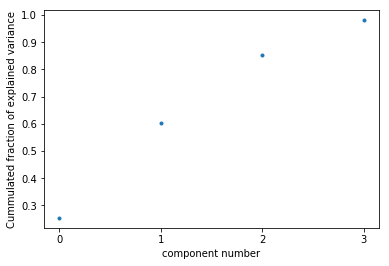

In [17]:
svd = TruncatedSVD(n_components=4)
svd_out = svd.fit_transform(df)

plt.plot(np.cumsum(svd.explained_variance_ratio_), '.')
plt.xlabel('component number')
plt.ylabel('Cummulated fraction of explained variance')
plt.xticks(range(4));